In [1]:
import datacq
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exogenous variable selection
## Data preparation

In [2]:
# Choose stations to analyse
stations = ['BETN043', 'BETN063', 'BETR222', 'BETR001'] # 'BETROO1', 'BELRL01'
types = {stat:datacq.STATIONS[stat]['description'] for stat in stations}

pollutants = ["SO2", "NO2", "CO", "O3", "PM2.5", "PM10"]

# Read era5 parameters from file
era5_params = datacq.era5.get_params_clean()

# Select time range
startYear = 2013
endYear = 2020
years = range(startYear,endYear+1)

In [3]:
#Retrieve data and construct variable name map ({'u10': '10m_u_component_of_wind',...})
df_dict = {}
var_maps = []
for stationCode in stations:
    df_dict[stationCode], var_map = datacq.get_df(years, stationCode, era5_params, pollutants)
    var_maps.append(var_map)
    
df = pd.concat(df_dict)
df.index.names = ['station', 'time']

#keys = set([key for var_map in var_maps for key in var_map.keys()])
#var_maps_master = {key: list(set([vm[key] for vm in var_maps])) for key in keys}
var_map = var_maps[0]

Station: BETN043
Retrieving pollution data...
Retrieving ERA5 data...
Station: BETN063
Retrieving pollution data...
Retrieving ERA5 data...
Station: BETR222
Retrieving pollution data...
Retrieving ERA5 data...
Station: BETR001
Retrieving pollution data...
Retrieving ERA5 data...


In [4]:
import dataprep

# Take daily averages, return nan when less 
# than max_nan hours are available for a day and variable
def daily_average(df, max_nan):
    df_D_nancount = (df
                    .isna()
                    .groupby([df.index.get_level_values('station')]
                            +[pd.Grouper(freq='D', level='time')])
                    .sum())

    df_D = (df.groupby([df.index.get_level_values('station')]
                        +[pd.Grouper(freq='D', level='time')])
                        .mean())
    df_D[df_D_nancount>max_nan] = np.nan
    # Remove hour data from index
    df_D.index = df_D.index.set_levels(pd.to_datetime(df_D.index.levels[1].date), level=1)
    return df_D


def shift_pollutants(df_D, pols):
    #Shift exogenous pollutant data one day forward
    pols_day0 = [pol+'_day0' for pol in pollutants]
    df_D.rename(dict(zip(pols,pols_day0)), axis=1, inplace=True)
    df_D['PM10'] = df_D['PM10_day0']

    df_D[pols_day0] = df_D.groupby(level='station')[pols_day0].shift(1)
    return df_D

pols_day0 = [pol+'_day0' for pol in pollutants]
df_D = (df
        .pipe(daily_average, max_nan=4)
        .pipe(dataprep.add_weeklyvars)
        .pipe(dataprep.add_dailyvars)
        .pipe(dataprep.add_workday)
        .pipe(shift_pollutants,pols=pollutants))

df_D

SO2_day0  NO2_day0  CO_day0  O3_day0  PM2.5_day0  \
station time                                                           
BETN043 2013-01-01       NaN       NaN      NaN      NaN         NaN   
        2013-01-02      2.76     30.23    89.55    36.04         NaN   
        2013-01-03      3.67     47.62   116.20    11.22       13.04   
        2013-01-04      3.04     39.78   101.66    14.81       18.14   
        2013-01-05      2.73     40.08    91.24    15.31       17.79   
...                      ...       ...      ...      ...         ...   
BETR222 2020-12-27      1.19     10.04   232.29    44.93        6.94   
        2020-12-28      0.87      1.38   167.73    59.75        0.00   
        2020-12-29      1.90     19.07   229.79    39.89        1.94   
        2020-12-30      1.17     26.85   286.36    19.19       10.57   
        2020-12-31      1.58     16.41   237.29    27.76        9.60   

                    PM10_day0    d2m    t2m  evabs   pev  ...  hcc  mcc  \
station time                                              ...             
BETN043 2013-01-01        NaN 277.49 279.40  -0.00 -0.00  ... 0.40 0.57   
        2013-01-02       9.88 276.72 278.53  -0.00 -0.00  ... 0.18 0.44   
        2013-01-03      22.94 281.72 282.50  -0.00 -0.00  ... 0.38 0.29   
        2013-01-04      25.40 280.77 282.17  -0.00 -0.00  ... 0.53 0.04   
        2013-01-05      25.02 279.85 281.00  -0.00 -0.00  ... 0.16 0.00   
...                       ...    ...    ...    ...   ...  ...  ...  ...   
BETR222 2020-12-27      10.18 274.46 276.23  -0.00 -0.00  ... 0.97 0.92   
        2020-12-28       0.07 274.21 275.60  -0.00 -0.00  ... 0.55 0.29   
        2020-12-29       2.96 273.45 274.84  -0.00 -0.00  ... 0.73 0.22   
        2020-12-30      14.75 274.31 275.56  -0.00 -0.00  ... 0.65 0.58   
        2020-12-31      12.67 274.04 274.81  -0.00 -0.00  ... 0.30 0.70   

                    w_speed  w_dir  weekly_sin  weekly_cos  daily_sin  \
station time                                                            
BETN043 2013-01-01     4.75   0.41        0.78        0.62       0.00   
        2013-01-02     3.69   0.57        0.97       -0.22       0.00   
        2013-01-03     3.92   0.41        0.43       -0.90       0.00   
        2013-01-04     3.32   0.09       -0.43       -0.90       0.00   
        2013-01-05     2.54   0.11       -0.97       -0.22       0.00   
...                     ...    ...         ...         ...        ...   
BETR222 2020-12-27    10.07   1.33       -0.78        0.62       0.00   
        2020-12-28     3.80   1.69        0.00        1.00       0.00   
        2020-12-29     3.60   0.76        0.78        0.62       0.00   
        2020-12-30     3.75   0.72        0.97       -0.22       0.00   
        2020-12-31     3.03   0.22        0.43       -0.90       0.00   

                    daily_cos  workday  PM10  
station time                                  
BETN043 2013-01-01       1.00        1  9.88  
        2013-01-02       1.00        1 22.94  
        2013-01-03       1.00        1 25.40  
        2013-01-04       1.00        1 25.02  
        2013-01-05       1.00        0 32.92  
...                       ...      ...   ...  
BETR222 2020-12-27       1.00        0  0.07  
        2020-12-28       1.00        1  2.96  
        2020-12-29       1.00        1 14.75  
        2020-12-30       1.00        1 12.67  
        2020-12-31       1.00        1  6.79  

[11688 rows x 41 columns]

## Data exploration

In [6]:
print("Percentage of missing values")
tot = len(df_D)
nanrates = df_D.isna().sum()/tot
nanrates.rename(index=var_map, inplace=True)
print(nanrates[nanrates!=0].sort_values(ascending=False).to_string())


Percentage of missing values
PM2.5_day0                    0.06
PM10_day0                     0.06
PM10                          0.06
SO2_day0                      0.04
O3_day0                       0.03
CO_day0                       0.03
soil_temperature_level_1      0.03
NO2_day0                      0.02
surface_net_solar_radiation   0.01


In [7]:
train_df_D = df_D[df_D.index.get_level_values('time').year<=2018]
val_df_D = df_D[df_D.index.get_level_values('time').year==2019]
test_df_D = df_D[df_D.index.get_level_values('time').year==2020]

In [8]:
from sklearn.preprocessing import StandardScaler
import scipy as sp

x_vars = list(train_df_D.columns)
x_vars.remove("PM10")
metrics = ['Pearson', 'Spearman']
cols = pd.MultiIndex.from_product([metrics, stations])
metrics_df = pd.DataFrame(index=x_vars, columns=cols)
for stat in stations:
    pm10 =train_df_D.loc[stat].PM10
    for var in x_vars:
        sc_X = StandardScaler()
        var_std = sc_X.fit_transform(train_df_D.loc[stat][var].values.reshape(-1, 1)).flatten()
        nans = np.logical_or(np.isnan(pm10), np.isnan(var_std))
        metrics_df.loc[var, ('Pearson', stat)] = abs(sp.stats.pearsonr(pm10[~nans], var_std[~nans])[0])
        metrics_df.loc[var, ('Spearman', stat)] = abs(sp.stats.spearmanr(pm10[~nans], var_std[~nans])[0])

metrics_df = metrics_df.rename(index=var_map)
metrics_df.sort_values(by=('Pearson', 'BETN043'), ascending=False, inplace=True)
metrics_df


Pearson                         Spearman  \
                                    BETN043 BETN063 BETR222 BETR001  BETN043   
PM10_day0                              0.63    0.71    0.71    0.71     0.60   
PM2.5_day0                             0.54    0.68    0.67    0.66     0.50   
boundary_layer_height                  0.49    0.55    0.50    0.50     0.56   
w_speed                                0.43    0.54    0.47    0.44     0.49   
NO2_day0                               0.37    0.66    0.65    0.59     0.31   
medium_cloud_cover                     0.33    0.32    0.34    0.32     0.41   
total_precipitation                    0.29    0.31    0.32    0.26     0.45   
surface_pressure                       0.27    0.32    0.32    0.31     0.31   
workday                                0.25    0.06    0.13    0.12     0.28   
surface_net_thermal_radiation          0.22    0.18    0.22    0.17     0.24   
SO2_day0                               0.21    0.14    0.06    0.38     0.13   
weekly_sin                             0.21    0.05    0.11    0.10     0.22   
surface_thermal_radiation_downwards    0.19    0.20    0.31    0.21     0.15   
O3_day0                                0.17    0.24    0.30    0.23     0.19   
sub_surface_runoff                     0.17    0.18    0.22    0.21     0.11   
surface_sensible_heat_flux             0.16    0.30    0.24    0.20     0.20   
high_cloud_cover                       0.16    0.20    0.24    0.16     0.17   
volumetric_soil_water_layer_4          0.14    0.16    0.19    0.19     0.11   
surface_runoff                         0.14    0.17    0.16    0.11     0.45   
soil_temperature_level_3               0.13    0.15    0.22    0.18     0.09   
soil_temperature_level_4               0.12    0.16    0.22    0.17     0.09   
weekly_cos                             0.11    0.08    0.09    0.10     0.08   
w_dir                                  0.11    0.34    0.32    0.28     0.09   
surface_net_solar_radiation            0.11    0.12    0.09    0.08     0.15   
soil_temperature_level_2               0.10    0.12    0.20    0.15     0.07   
surface_solar_radiation_downwards      0.10    0.12    0.09    0.08     0.15   
volumetric_soil_water_layer_3          0.10    0.08    0.13    0.16     0.04   
2m_dewpoint_temperature                0.09    0.16    0.27    0.16     0.04   
potential_evaporation                  0.09    0.10    0.01    0.13     0.09   
yearly_sin                             0.09    0.14    0.20    0.14     0.06   
evaporation_from_bare_soil             0.09    0.07    0.03    0.06     0.12   
runoff                                 0.08    0.11    0.15    0.12     0.02   
soil_temperature_level_1               0.08    0.11    0.19    0.13     0.05   
2m_temperature                         0.08    0.13    0.20    0.14     0.04   
skin_temperature                       0.07    0.11    0.19    0.12     0.03   
surface_latent_heat_flux               0.06    0.08    0.13    0.09     0.09   
evaporation                            0.06    0.08    0.13    0.09     0.09   
yearly_cos                             0.05    0.02    0.08    0.07     0.01   
CO_day0                                0.02    0.42    0.47    0.43     0.02   
volumetric_soil_water_layer_2          0.01    0.07    0.02    0.04     0.08   

                                                             
                                    BETN063 BETR222 BETR001  
PM10_day0                              0.70    0.69    0.68  
PM2.5_day0                             0.66    0.65    0.60  
boundary_layer_height                  0.62    0.55    0.55  
w_speed                                0.62    0.53    0.50  
NO2_day0                               0.68    0.64    0.58  
medium_cloud_cover                     0.41    0.42    0.41  
total_precipitation                    0.46    0.46    0.44  
surface_pressure                       0.38    0.36    0.36  
workday                                0.05    0.13    

suburban - Industrial


rural - Background


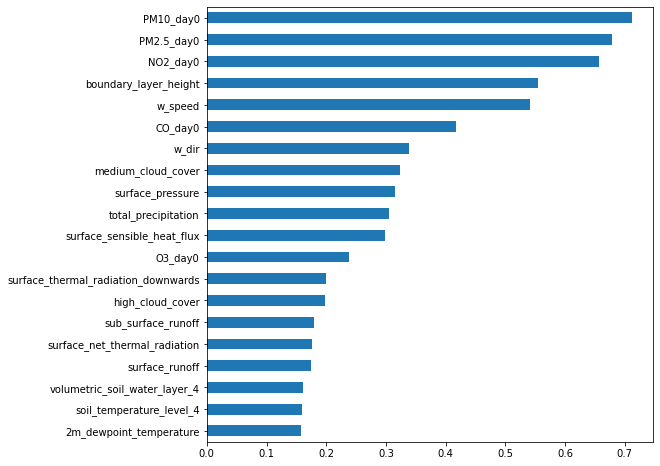

suburban - Background


urban - Traffic


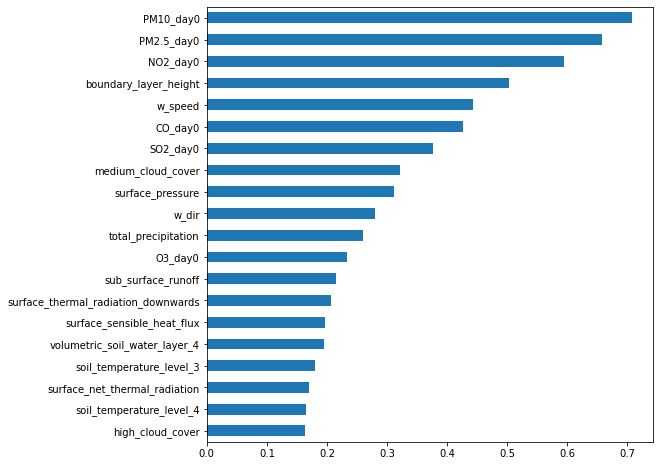

In [9]:
metr = 'Pearson'
#metrics_era5 = metrics_df.loc[[var for var in metrics_df.index if "day0" not in var]]
for stat in stations:
    print(types[stat])
    plt.figure()
    metrics_df[(metr,stat)].sort_values(ascending=True).tail(20).plot.barh(figsize=(8, 8))
    plt.show()


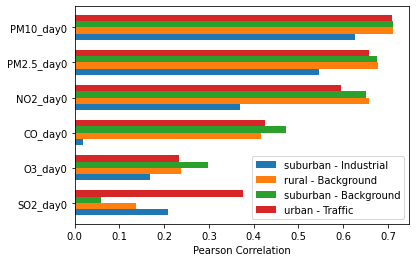

In [45]:
metr = 'Pearson'
pol_petrics = metrics_df.loc[pols_day0]
pol_petrics[metr].sort_values(by='BETN063', ascending=True).plot.barh(width=0.7)
L = plt.legend()
for t in L.get_texts():
    t.set_text(types[t.get_text()])

plt.xlabel('Pearson Correlation')
plt.show()

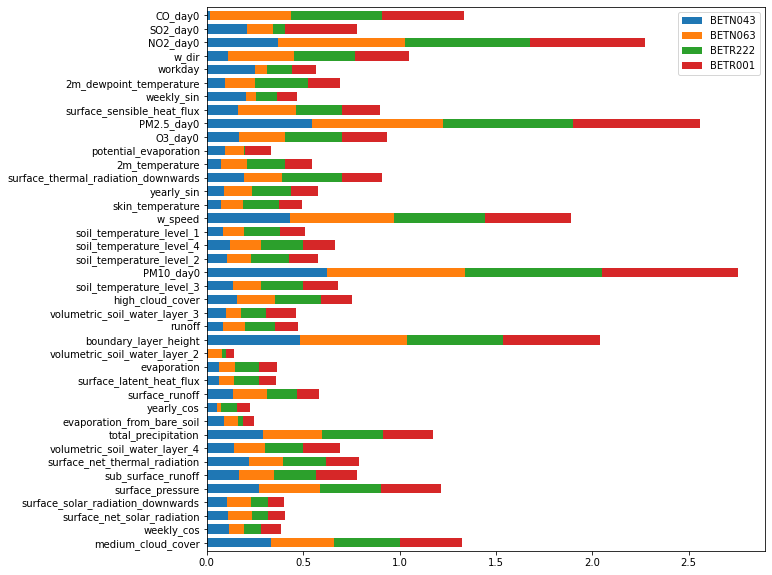

In [46]:
pearson_corr = metrics_df['Pearson'].copy()
pearson_corr['range'] = np.ptp(metrics_df['Pearson'].values, axis=1)
pearson_corr.sort_values(by='range', ascending=True, inplace=True)

pearson_corr[stations].tail(50).plot.barh(width=0.7, stacked=True, figsize=(10,10))
plt.show()

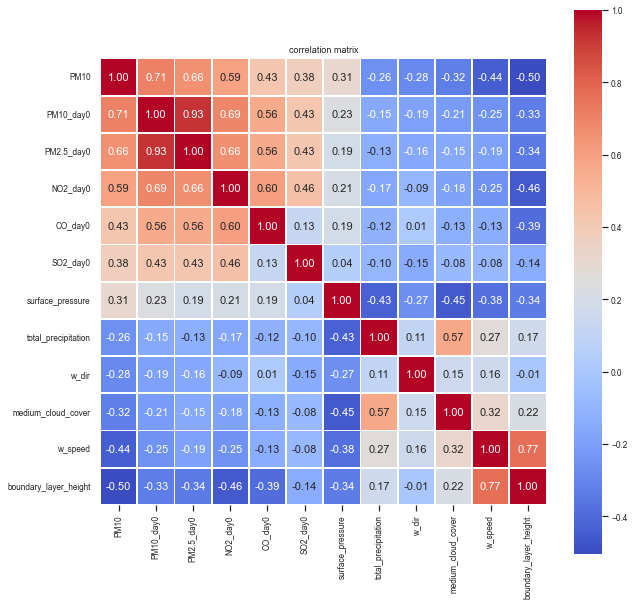

In [47]:
stat = 'BETR001'
threshold=0.25
high_corr_vars = ['PM10'] + list(metrics_df[metrics_df['Pearson',stat]>threshold].index.values)
df_high_corr = train_df_D.loc[stat].rename(columns=var_map)[high_corr_vars]

idx = df_high_corr.corr().sort_values(by='PM10', ascending=False).index
plt.figure(figsize = (10,10))
sns.set(font_scale=0.75)
ax = sns.heatmap(df_high_corr[idx].corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

### Boruta-Shap

In [10]:
from BorutaShap import BorutaShap
target = 'PM10'
features = list(train_df_D.columns)
features.remove(target)

In [33]:
selectors = {}                           
for stat in stations:
    Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=False)
    df = train_df_D.loc[stat].dropna()
    Feature_Selector.fit(X=df[features], y=df[target], n_trials=100, sample=False,
        train_or_test = 'test', normalize=True,
        verbose=True)
    selectors[stat] = Feature_Selector

  0%|          | 0/100 [00:00<?, ?it/s]

15 attributes confirmed important: ['evabs', 'str', 'swvl4', 'PM2.5_day0', 'w_speed', 'workday', 'weekly_sin', 'w_dir', 'ssro', 'mcc', 'blh', 'CO_day0', 'stl4', 'tp', 'PM10_day0']
24 attributes confirmed unimportant: ['strd', 'stl2', 'yearly_cos', 'sp', 'sro', 'NO2_day0', 'ro', 'ssr', 'stl1', 'ssrd', 'slhf', 'weekly_cos', 'stl3', 'SO2_day0', 'yearly_sin', 'swvl3', 'e', 'pev', 'swvl2', 'skt', 't2m', 'hcc', 'O3_day0', 'd2m']
1 tentative attributes remains: ['sshf']


  0%|          | 0/100 [00:00<?, ?it/s]

16 attributes confirmed important: ['sshf', 'PM2.5_day0', 'w_speed', 'w_dir', 'O3_day0', 'mcc', 'yearly_sin', 'sp', 'blh', 'sro', 'NO2_day0', 'stl4', 'CO_day0', 'tp', 'd2m', 'PM10_day0']
24 attributes confirmed unimportant: ['strd', 'swvl4', 'stl2', 'yearly_cos', 'ro', 'ssr', 'stl1', 'evabs', 'ssrd', 'slhf', 'weekly_cos', 'stl3', 'workday', 'SO2_day0', 'swvl3', 'e', 'pev', 'swvl2', 'skt', 'str', 'weekly_sin', 'ssro', 't2m', 'hcc']
0 tentative attributes remains: []


  0%|          | 0/100 [00:00<?, ?it/s]

20 attributes confirmed important: ['strd', 'w_speed', 'mcc', 'sp', 'sro', 'NO2_day0', 'CO_day0', 'PM10_day0', 'tp', 'sshf', 'stl3', 'PM2.5_day0', 'w_dir', 'yearly_sin', 'swvl3', 'stl4', 'str', 'weekly_sin', 'blh', 'd2m']
18 attributes confirmed unimportant: ['evabs', 'weekly_cos', 'ssrd', 'swvl4', 'SO2_day0', 'workday', 'slhf', 'pev', 'yearly_cos', 'ssro', 'O3_day0', 'ro', 'e', 'ssr', 'hcc', 'swvl2', 'stl1', 'skt']
2 tentative attributes remains: ['t2m', 'stl2']


  0%|          | 0/100 [00:00<?, ?it/s]

20 attributes confirmed important: ['swvl4', 'strd', 'w_speed', 'mcc', 'NO2_day0', 'ro', 'PM10_day0', 'evabs', 'ssrd', 'tp', 'sshf', 'stl3', 'PM2.5_day0', 'SO2_day0', 'w_dir', 'yearly_sin', 'swvl3', 'str', 'weekly_sin', 'blh']
19 attributes confirmed unimportant: ['stl2', 'yearly_cos', 'sp', 'sro', 'CO_day0', 'ssr', 'stl1', 'slhf', 'weekly_cos', 'workday', 'stl4', 'e', 'pev', 'swvl2', 'skt', 't2m', 'hcc', 'O3_day0', 'd2m']
1 tentative attributes remains: ['ssro']


In [4]:
Feature_Selector.plot(which_features='all')

NameError: name 'Feature_Selector' is not defined

In [29]:
Feature_Selector.results_to_csv(filename='feature_importance')

## Prediction


In [49]:
from sklearn.pipeline import Pipeline

target = 'PM10'
features = list(train_df_D.columns)
features.remove(target)

### Linear regression

In [52]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        # Fit a model with every possible extra feature
        for new_feature in remaining_features:
            ols_fit = sm.OLS(target, sm.add_constant(data[best_features+[new_feature]])).fit()
            new_pval[new_feature] = ols_fit.pvalues[new_feature]
        # Find the most relevant new feature (lowest p-value)
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            # Add the new feature to the list of best features
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                # Check if any of the current best features is not significant
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    # If it is not significant, remove it from the list of best features
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features



In [82]:
best_features = {}
for stat in stations:
    df = train_df_D.loc[stat].dropna()
    best_features[stat] = stepwise_selection(df[features], df[target])

In [65]:
ols_models = {}
for stat in stations:
    df = train_df_D.loc[stat].dropna()
    ols_pipe = Pipeline([('scaler', StandardScaler()),
                            ('ols', LinearRegression())])
    ols_models[stat] = ols_pipe.fit(df[best_features[stat]], np.log(1+df[target]))

In [87]:
common_features = list(set.intersection(*map(set, best_features.values())))
best_features['BETN063']

['PM10_day0',
 'w_speed',
 'NO2_day0',
 'w_dir',
 'blh',
 'O3_day0',
 'tp',
 'stl4',
 'workday',
 'sp',
 'mcc']

'potential_evaporation'

In [70]:
import eval
metrics = eval.metrics
ols_results = pd.DataFrame(columns=stations, index=metrics.keys())
for stat in stations:
    model = ols_models[stat]
    df_val = val_df_D.loc[stat].dropna()
    y_val_pred = np.exp(model.predict(df_val[best_features[stat]]))-1
    y_val_true = df_val['PM10']
    ols_results.loc[stat] = eval.evaluate(y_val_true, y_val_pred)
ols_results


/Users/mauritsdescamps/OneDrive/Studie/AI/Thesis/thesis_pm/code/eval.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(y_true,y_pred) / np.nanmean(np.abs(y_true[1:] - y_persistence))
/Users/mauritsdescamps/OneDrive/Studie/AI/Thesis/thesis_pm/code/eval.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(y_true,y_pred) / np.nanmean(np.abs(y_true[1:] - y_persistence))
/Users/mauritsdescamps/OneDrive/Studie/AI/Thesis/thesis_pm/code/eval.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(y_true,y_pred) / np.nanmean(np.abs(y_true[1:] - y_persistence))
/Users/mauritsdescamps/OneDrive/Studie/AI/Thesis/thesis_pm/code/eval.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(y_true,y_pred) / np.nanmean(np.abs(y_true[1:] - y_persistence))


BETN043 BETN063 BETR222 BETR001
smape       NaN     NaN     NaN     NaN
mae         NaN     NaN     NaN     NaN
mase        NaN     NaN     NaN     NaN
rmse        NaN     NaN     NaN     NaN
BETN043     NaN     NaN     NaN     NaN
BETN063     NaN     NaN     NaN     NaN
BETR222     NaN     NaN     NaN     NaN
BETR001     NaN     NaN     NaN     NaN